# Multi-armed Bandit

Given a a number of slot machines with different reward probabilities, the goal is to decide which one to play in order to maximize the sum of rewards. The reward probabilities are unknown; the only feedback is the random reward when pulling an arm. In every iteration, we are confronted with the decision if we should pull the arm with the so far highest mean reward or pull a different one. While the former optimizes (locally) the overall reward, the second may allow us to identify an arm with higher reward. This tradeoff between improving the estimate (and confidence) of the arms' reward probabilities versus optimizing for the overall reward given the current estimates is known as the exploration/exploitation dilemma and is the core of many reinforcement learning problems.

This notebook demonstrates the basic idea of some popular heuristics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

For the sake of simplicity we assume that the reward given a specific arm is either one or zero. Let's start with defining the success probability. Whenever an arm is pulled, the machine is flipping a coin with the corresponding success probability. If it shows head, the machine returns a reward, otherwise not.

In [2]:
rewards_mu = [
    0.3, 0.9, 0.85, 0.5
]
num_arms = len(rewards_mu)

def get_reward(i):
    return int(np.random.rand() < rewards_mu[i])

The experiment is as follows: We pull every arm once in a random order. After that we apply a policy (given the past rewards) which arm to pull next. Finally, we report the total rewards. In order to evaluate the performance of a policy, we repeat the experiment multiple times and take the average over these outcomes as an estimate of the expected reward.

In [3]:
def estimate_expectation(policy, num_trials, num_reps=1000):
    def run_experiment():
        # init
        chosen_arms = np.zeros((num_trials, num_arms))
        rewards_per_arm = np.zeros((num_trials, num_arms))
        for i, choice in enumerate(np.random.permutation(num_arms).astype(int)):
            chosen_arms[i, choice] = 1
            rewards_per_arm[i, choice] = get_reward(choice)

        # play machines
        for i in range(num_arms, num_trials):        
            choice = policy(rewards_per_arm[:i, :].sum(axis=0), chosen_arms.sum(axis=0))
            chosen_arms[i, choice] = 1
            rewards_per_arm[i, choice] = get_reward(choice)
            
        return rewards_per_arm.sum(axis=1).cumsum(axis=0), chosen_arms.cumsum(axis=0)

    # repeat experiment and compute average
    avg_cum_rewards = np.zeros(num_trails)
    avg_cum_chosen_arms = np.zeros((num_trials, num_arms))
    for i in range(num_reps):
        cum_rewards, cum_chosen_arms = run_experiment()
        avg_cum_rewards += cum_rewards
        avg_cum_chosen_arms += cum_chosen_arms

    return avg_cum_rewards/float(num_reps), avg_cum_chosen_arms/float(num_reps)

The policies under study are:
- `epsilon_greedy`: In 1-epsilon of the cases, we pull the arm with highest success so far. Otherwise, we choose the arm randomly; epsilon is the trade-off between exploration and exploitation.
- `ucb1`: Pull the arm with highest upper confidence bound. The upper confidence bound is high, if the estimated reward probability is high or the confidence  is low (arm is pulled only a few times).
- `thompson`: We draw a sample from the posterior distribution for each arm and take the highest one. The posterior combines the prior knowledge and the likelihood of the observations. The more outcomes we have observed, the more is the distribution peaked around the reward probability.

In [4]:
def epsilon_greedy(epsilon):
    def run(total_rewards_per_arm, num_chosen_arm):
        if np.random.rand() > epsilon:
            means_per_arm = total_rewards_per_arm/num_chosen_arm
            return means_per_arm.argmax()
        else:
            return np.random.randint(0, num_arms)
    return run

def ucb1():
    def run(total_rewards_per_arm, num_chosen_arm):
        means_per_arm = total_rewards_per_arm/num_chosen_arm
        uncertainty_per_arm = np.array([np.sqrt(2*np.log(num_chosen_arm.sum()) / arm_chosen) for arm_chosen in num_chosen_arm])
        return (means_per_arm + uncertainty_per_arm).argmax()
    return run

def thompson():
    def run(total_rewards_per_arm, num_chosen_arm):
        theta = np.array([np.random.beta(total_rewards + 1, chosen_arm - total_rewards + 1) for total_rewards, chosen_arm in zip(total_rewards_per_arm, num_chosen_arm)])
        return theta.argmax()
    return run

Get results for policies under study.

In [5]:
num_trails = 1000
results = {
    'ucb1': estimate_expectation(ucb1(), num_trails),
    'thompson': estimate_expectation(thompson(), num_trails),
    'eps-greedy(0.05)': estimate_expectation(epsilon_greedy(0.05), num_trails),
    'eps-greedy(0.1)': estimate_expectation(epsilon_greedy(0.1), num_trails),
    'eps-greedy(0.5)': estimate_expectation(epsilon_greedy(0.5), num_trails),
}

In the following, we are plotting the regrets (difference between maximal possible and actual rewards) against the number of draws.

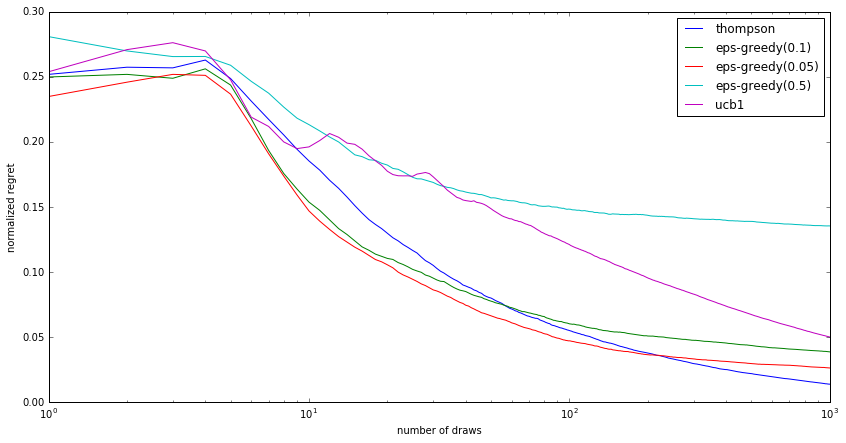

In [6]:
draws = np.arange(num_trails) + 1
plt.figure(figsize=(14, 7))
for meth, result in results.items():
    total_reward, _ = result
    plt.semilogx(draws, max(rewards_mu)-total_reward/draws)

plt.ylabel('Regrets per Method')
plt.ylabel('normalized regret')
plt.xlabel('number of draws')
plt.legend(results.keys())

We can see that `ucb1` and `thompson`-sampling converge to the a zero regret, where the convergence rate of the later seems to be faster. However, note that `thompson` depends on the regret probability distribution, which might not be known in practice. Also the `epsilon_greedy` policies (for some epsilon) show a better performance than `ucb1`. However, this policies never converges to the best regret, because it samples with epsilon probability always a random arm. Also, the best `epsilon` is typically unknown in practice; a bad `epsilon` may result in a bad performance.

Finally, let's see how often each arm was actually drawn when following a specific policy.

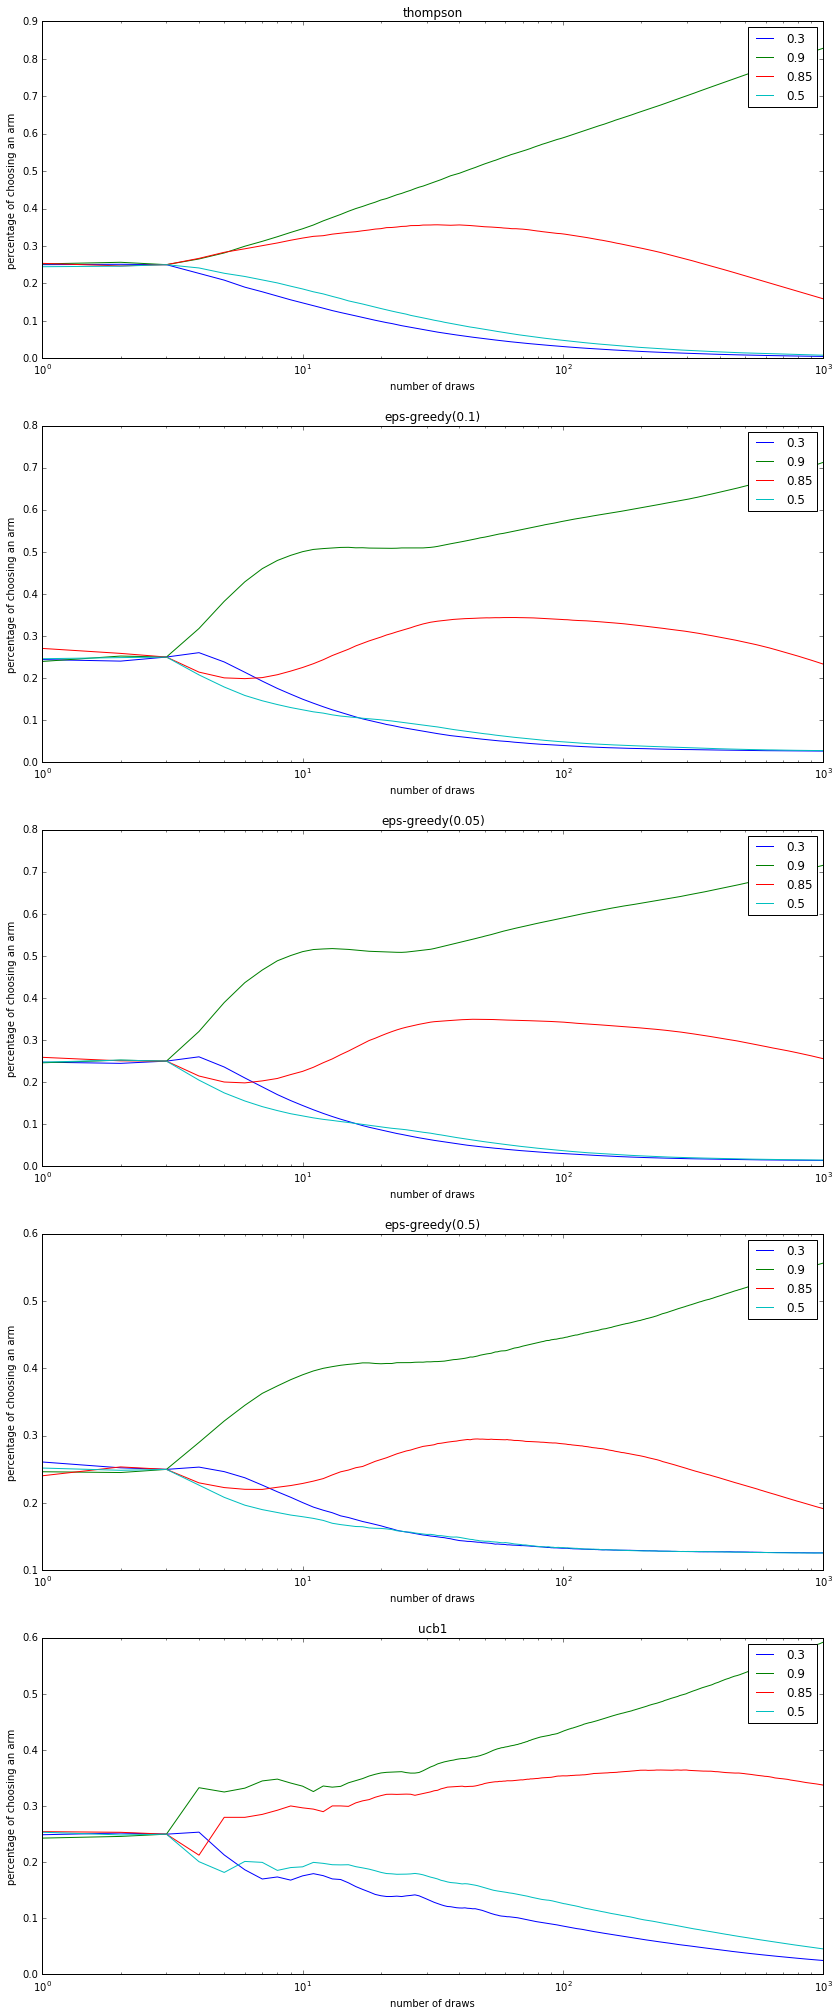

In [7]:
f, ax = plt.subplots(len(results), figsize=(14, len(results)*7))

for i, (meth, result) in enumerate(results.items()):
    _, chosen_arms = result
    for j in range(num_arms):
        ax[i].semilogx(chosen_arms[:, j]/draws)
    ax[i].legend(rewards_mu)
    ax[i].set_xlabel('number of draws')
    ax[i].set_ylabel('percentage of choosing an arm')
    ax[i].set_title(meth)

After the initial phase, where we draw every arm once, we see different selection probabilties. Where the `epsilon_greedy` policies pull every arm at least `epsilon/#arms`, the probability of chosen an inferior arm converges to zero for the `thompson` and `ucb1`. Note that there is a clear difference between the two arms with high and the two arms with low reward probability. Each policy needs a different level of confidence before an inferior arm is neglected.